<a href="https://colab.research.google.com/github/Redinela2001/XLM_RoBERTa_Cool_4/blob/main/fleiss_kappa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# If you're on Colab, this is all you need.
!pip -q install openpyxl

import io
import numpy as np
import pandas as pd

# Utility: pretty printing
pd.set_option("display.max_rows", 10)
pd.set_option("display.width", 120)


In [2]:
from google.colab import files

print("➡️ Choose your Excel file (.xlsx)")
uploaded = files.upload()

# Grab the uploaded filename
FILENAME = next(iter(uploaded))
print("Uploaded:", FILENAME)


➡️ Choose your Excel file (.xlsx)


Saving Fleiss'.xlsx to Fleiss'.xlsx
Uploaded: Fleiss'.xlsx


In [6]:
# 🔧 Define the columns you want to keep
columns_to_keep = ["Occurrences", "Annotator_1", "Annotator_2", "XLM-RoBERTa"]

# 🧹 Drop all other columns (like "Unnamed: 4", etc.)
df_cleaned = df_raw[columns_to_keep].copy()

# 🔎 Preview the cleaned DataFrame
print("✅ Cleaned data (only selected columns):")
display(df_cleaned.head())


✅ Cleaned data (only selected columns):


,Occurrences,Annotator_1,Annotator_2,XLM-RoBERTa
0,"we sat , after the long hot drive , drinking c...",Basic,Basic,Basic
1,till they saw me and swirled down again to the...,Emotion,Nonliteral,Emotion
2,a pot that has been boiling furiously does n't...,Basic,Basic,Basic
3,"are observed here on the cool earth , whilesta...",Basic,Basic,Basic
4,hygienic merits of pipes : a soft clay is inva...,Basic,Basic,Basic


In [7]:
# 🧼 Clean the labels: lowercase and strip spaces
for col in ["Annotator_1", "Annotator_2", "XLM-RoBERTa"]:
    df_cleaned[col] = df_cleaned[col].astype(str).str.strip().str.lower().replace({"": np.nan})

# 🧹 Drop rows with missing values (if any annotator didn't annotate)
df_cleaned = df_cleaned.dropna(subset=["Annotator_1", "Annotator_2", "XLM-RoBERTa"])

# 🔁 Build count matrix from the 3 annotators
annotator_cols = ["Annotator_1", "Annotator_2", "XLM-RoBERTa"]
label_df = df_cleaned[annotator_cols]

# 🔢 Count how many times each category was chosen per item
all_cats = sorted(pd.unique(label_df.values.ravel()))
count_df = pd.DataFrame(0, index=label_df.index, columns=all_cats)

# Fill count matrix
for col in annotator_cols:
    count_df = count_df.add(pd.get_dummies(label_df[col]), fill_value=0).astype(int)

# ✅ Attach Occurrences back (optional, for reference)
count_df.insert(0, "Occurrences", df_cleaned["Occurrences"].values)

# 🔎 Preview
print("🎯 Count matrix used for Fleiss’ κ:")
display(count_df.head())


🎯 Count matrix used for Fleiss’ κ:


,Occurrences,basic,emotion,nonliteral
0,"we sat , after the long hot drive , drinking c...",3,0,0
1,till they saw me and swirled down again to the...,0,2,1
2,a pot that has been boiling furiously does n't...,3,0,0
3,"are observed here on the cool earth , whilesta...",3,0,0
4,hygienic merits of pipes : a soft clay is inva...,3,0,0


In [8]:
def fleiss_kappa(count_df: pd.DataFrame, n_raters: int):
    cat_counts = count_df.iloc[:, 1:].astype(float)  # exclude Occurrences
    n_items, n_cats = cat_counts.shape

    # Check that all rows sum to n_raters
    row_sum = cat_counts.sum(axis=1)
    if not np.allclose(row_sum.values, n_raters):
        raise ValueError("Each row must sum to the same number of raters.")

    p_j = cat_counts.sum(axis=0) / (n_items * n_raters)
    P_e = (p_j ** 2).sum()
    P_i = (cat_counts.pow(2).sum(axis=1) - n_raters) / (n_raters * (n_raters - 1))
    P_bar = P_i.mean()
    kappa = (P_bar - P_e) / (1 - P_e) if (1 - P_e) != 0 else np.nan

    return {
        "kappa": kappa,
        "P_bar": P_bar,
        "P_e": P_e,
        "category_prevalence": p_j,
        "item_agreement": P_i
    }

# 🧮 Compute Fleiss' kappa
N_ANNOTATORS = 3
results = fleiss_kappa(count_df, N_ANNOTATORS)

# 📊 Output
print(f"📌 Fleiss’ κ: {results['kappa']:.4f}")
print(f"   Mean observed agreement (P̄): {results['P_bar']:.4f}")
print(f"   Chance agreement (Pₑ): {results['P_e']:.4f}")


📌 Fleiss’ κ: 0.7683
   Mean observed agreement (P̄): 0.8509
   Chance agreement (Pₑ): 0.3564


In [9]:
# 🗂️ Category prevalence (how often each label was chosen overall)
print("\n📊 Category prevalence (across all annotations):")
display(results["category_prevalence"].to_frame("prevalence").rename_axis("category"))

# 📍 Per-item agreement score
agreement_df = pd.DataFrame({
    "Occurrences": count_df["Occurrences"],
    "P_i": results["item_agreement"]
})
print("\n🧭 Agreement per item:")
display(agreement_df.head())



📊 Category prevalence (across all annotations):


,prevalence
category,
basic,0.453216
emotion,0.245614
nonliteral,0.301170



🧭 Agreement per item:


,Occurrences,P_i
0,"we sat , after the long hot drive , drinking c...",1.000000
1,till they saw me and swirled down again to the...,0.333333
2,a pot that has been boiling furiously does n't...,1.000000
3,"are observed here on the cool earth , whilesta...",1.000000
4,hygienic merits of pipes : a soft clay is inva...,1.000000


In [10]:
out_file = "fleiss_kappa_output.xlsx"

with pd.ExcelWriter(out_file, engine="openpyxl") as writer:
    count_df.to_excel(writer, index=False, sheet_name="count_matrix")
    agreement_df.to_excel(writer, index=False, sheet_name="item_agreement")
    results["category_prevalence"].to_frame("prevalence").to_excel(writer, sheet_name="category_prevalence")

# Offer download
from google.colab import files
files.download(out_file)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aesthetic setup
sns.set(style="whitegrid", palette="muted", font_scale=1.2)


/tmp/ipython-input-286615083.py:9: UserWarning: Glyph 128290 (\N{INPUT SYMBOL FOR NUMBERS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128290 (\N{INPUT SYMBOL FOR NUMBERS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


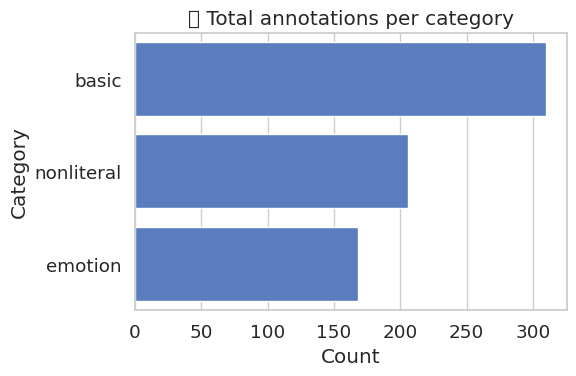

In [12]:
# Flatten all labels into one series
all_labels_flat = pd.concat([df_cleaned[col] for col in annotator_cols], axis=0)

plt.figure(figsize=(6,4))
sns.countplot(y=all_labels_flat, order=all_labels_flat.value_counts().index)
plt.title("🔢 Total annotations per category")
plt.xlabel("Count")
plt.ylabel("Category")
plt.tight_layout()
plt.show()


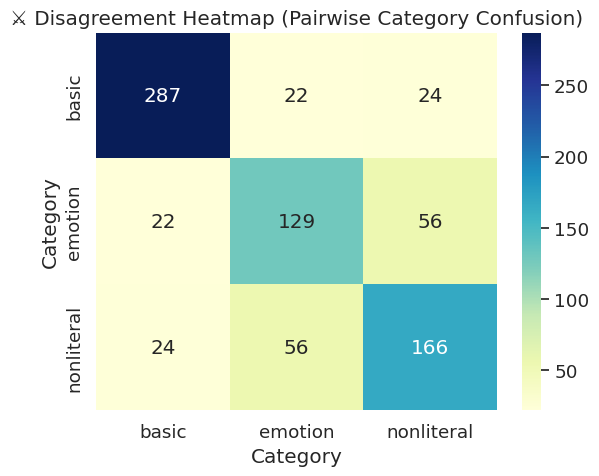

In [13]:
from itertools import combinations
from collections import Counter

# Build disagreement matrix
pairs = [tuple(sorted(p)) for row in df_cleaned[annotator_cols].values for p in combinations(row, 2)]
pair_counts = Counter(pairs)

categories = sorted(pd.unique(all_labels_flat))
disagree_matrix = pd.DataFrame(0, index=categories, columns=categories)

for (cat1, cat2), count in pair_counts.items():
    disagree_matrix.loc[cat1, cat2] += count
    if cat1 != cat2:
        disagree_matrix.loc[cat2, cat1] += count

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(disagree_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("⚔️ Disagreement Heatmap (Pairwise Category Confusion)")
plt.xlabel("Category")
plt.ylabel("Category")
plt.tight_layout()
plt.show()


/tmp/ipython-input-825616775.py:6: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


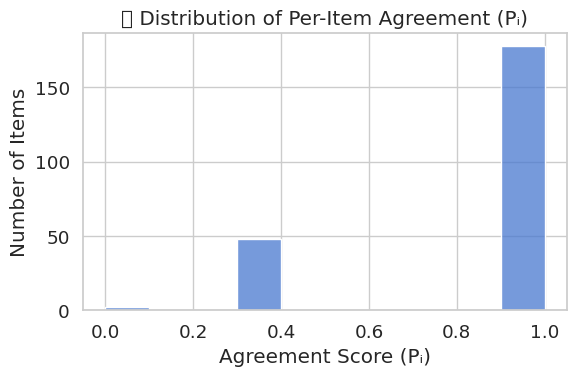

In [14]:
plt.figure(figsize=(6,4))
sns.histplot(results["item_agreement"], bins=10, kde=False)
plt.title("📏 Distribution of Per-Item Agreement (Pᵢ)")
plt.xlabel("Agreement Score (Pᵢ)")
plt.ylabel("Number of Items")
plt.tight_layout()
plt.show()


In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Ensure all labels are clean and lowercase
for col in ["Annotator_1", "Annotator_2", "XLM-RoBERTa"]:
    df_cleaned[col] = df_cleaned[col].astype(str).str.strip().str.lower().replace({"": np.nan})

# Drop rows where any label is missing
df_eval = df_cleaned.dropna(subset=["Annotator_1", "Annotator_2", "XLM-RoBERTa"]).copy()

# Define labels
labels = sorted(pd.unique(df_eval[["Annotator_1", "Annotator_2", "XLM-RoBERTa"]].values.ravel()))


🧪 XLM-RoBERTa vs Annotator_1
Accuracy: 0.9342105263157895

Classification Report:
              precision    recall  f1-score   support

       basic      0.953     0.971     0.962       104
     emotion      0.898     0.964     0.930        55
  nonliteral      0.937     0.855     0.894        69

    accuracy                          0.934       228
   macro avg      0.929     0.930     0.929       228
weighted avg      0.935     0.934     0.934       228



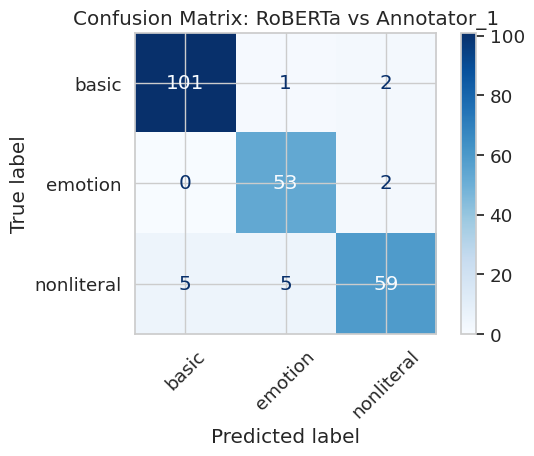

In [16]:
from sklearn.metrics import accuracy_score

print("🧪 XLM-RoBERTa vs Annotator_1")
y_true_1 = df_eval["Annotator_1"]
y_pred = df_eval["XLM-RoBERTa"]

print("Accuracy:", accuracy_score(y_true_1, y_pred))
print("\nClassification Report:")
print(classification_report(y_true_1, y_pred, labels=labels, digits=3))

# Confusion Matrix
cm = confusion_matrix(y_true_1, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix: RoBERTa vs Annotator_1")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


🧪 XLM-RoBERTa vs Annotator_2
Accuracy: 0.8026315789473685

Classification Report:
              precision    recall  f1-score   support

       basic      0.877     0.930     0.903       100
     emotion      0.661     0.722     0.690        54
  nonliteral      0.810     0.689     0.745        74

    accuracy                          0.803       228
   macro avg      0.783     0.780     0.779       228
weighted avg      0.804     0.803     0.801       228



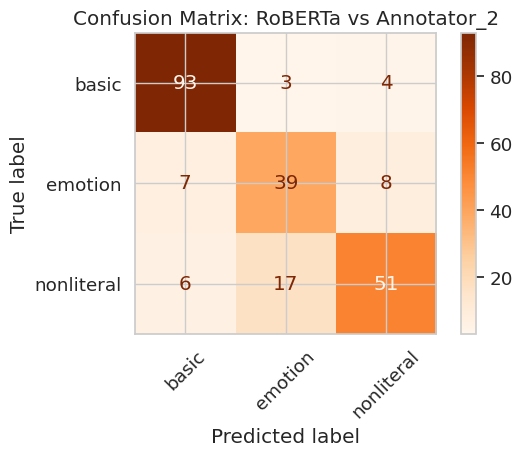

In [17]:
print("🧪 XLM-RoBERTa vs Annotator_2")
y_true_2 = df_eval["Annotator_2"]

print("Accuracy:", accuracy_score(y_true_2, y_pred))
print("\nClassification Report:")
print(classification_report(y_true_2, y_pred, labels=labels, digits=3))

# Confusion Matrix
cm = confusion_matrix(y_true_2, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Oranges")
plt.title("Confusion Matrix: RoBERTa vs Annotator_2")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [18]:
from sklearn.metrics import classification_report
import pandas as pd

# True labels
y1 = df_eval["Annotator_1"]
y2 = df_eval["Annotator_2"]
y_roberta = df_eval["XLM-RoBERTa"]

labels = sorted(set(y1) | set(y2) | set(y_roberta))

# Classification reports
report_vs_ann1 = classification_report(y1, y_roberta, labels=labels, output_dict=True)
report_vs_ann2 = classification_report(y2, y_roberta, labels=labels, output_dict=True)

# Extract per-label F1s
f1_ann1 = {k: v["f1-score"] for k, v in report_vs_ann1.items() if k in labels}
f1_ann2 = {k: v["f1-score"] for k, v in report_vs_ann2.items() if k in labels}

df_f1 = pd.DataFrame({
    "F1 vs Annotator_1": pd.Series(f1_ann1),
    "F1 vs Annotator_2": pd.Series(f1_ann2)
})


/tmp/ipython-input-1968440870.py:6: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


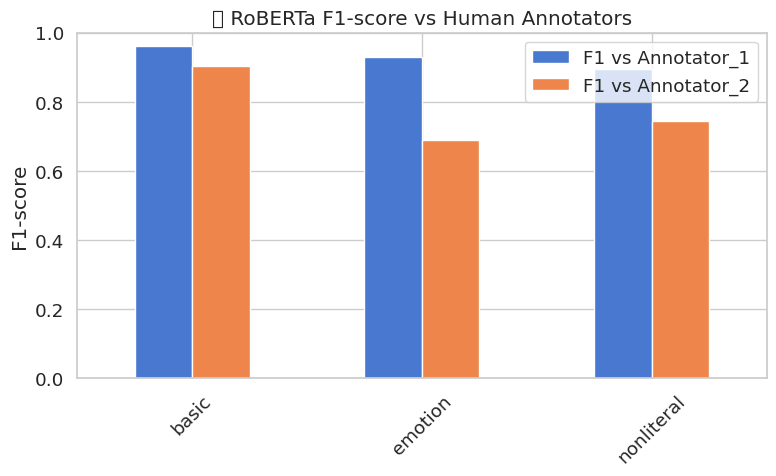

In [19]:
df_f1.plot(kind="bar", figsize=(8, 5))
plt.title("📊 RoBERTa F1-score vs Human Annotators")
plt.ylabel("F1-score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipython-input-1470394107.py:18: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


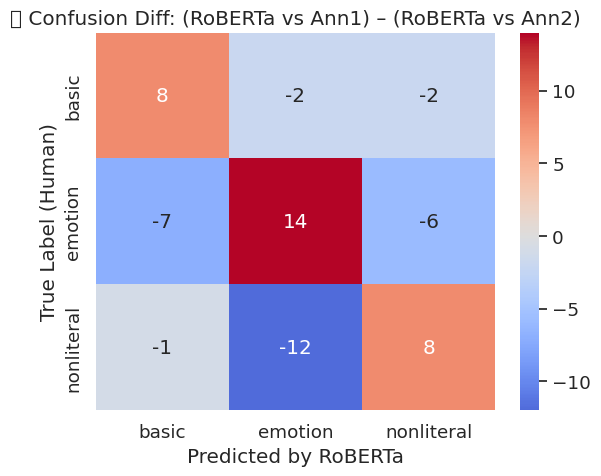

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Get confusion matrices
cm1 = confusion_matrix(y1, y_roberta, labels=labels)
cm2 = confusion_matrix(y2, y_roberta, labels=labels)

# Convert to differences
diff_matrix = cm1 - cm2
diff_df = pd.DataFrame(diff_matrix, index=labels, columns=labels)

plt.figure(figsize=(6,5))
sns.heatmap(diff_df, annot=True, cmap="coolwarm", center=0, fmt="d")
plt.title("🔥 Confusion Diff: (RoBERTa vs Ann1) – (RoBERTa vs Ann2)")
plt.xlabel("Predicted by RoBERTa")
plt.ylabel("True Label (Human)")
plt.tight_layout()
plt.show()


In [21]:
# Build majority vote (if Ann1 == Ann2, use it; else mark as "conflict")
def majority_vote(row):
    if row["Annotator_1"] == row["Annotator_2"]:
        return row["Annotator_1"]
    else:
        return np.nan  # Skip conflicts for now

df_eval["majority_label"] = df_eval.apply(majority_vote, axis=1)

# Drop NA (where annotators disagreed)
df_majority = df_eval.dropna(subset=["majority_label"])

# Evaluate Roberta vs Majority
from sklearn.metrics import accuracy_score, classification_report

y_gold = df_majority["majority_label"]
y_roberta_majority = df_majority["XLM-RoBERTa"]

print("🤝 RoBERTa vs Majority Vote")
print("Accuracy:", accuracy_score(y_gold, y_roberta_majority))
print("\nClassification Report:")
print(classification_report(y_gold, y_roberta_majority, labels=labels, digits=3))


🤝 RoBERTa vs Majority Vote
Accuracy: 0.956989247311828

Classification Report:
              precision    recall  f1-score   support

       basic      0.968     0.989     0.979        93
     emotion      0.923     0.973     0.947        37
  nonliteral      0.962     0.893     0.926        56

    accuracy                          0.957       186
   macro avg      0.951     0.952     0.951       186
weighted avg      0.957     0.957     0.957       186

